# Import libraries
For this work we need some basic libraries, like `pandas`, `numpy`, `cv2`, `collections`, `matplotlib`, as weel as, `DataLoader`, `Image`, `tqdm`.
Here we also mount the notebook to the Google Drive to load the datasets.


In [34]:
import os
import pandas as pd
import numpy as np
import torch
import cv2
import collections
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp
! pip install -U git+https://github.com/albu/albumentations --no-cache-dir
# ! pip install --upgrade albumentations
import albumentations as A

import json
from tqdm import tqdm

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from glob import glob
from os import path
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch

%matplotlib inline

from google.colab import drive
drive.mount("/content/drive/",force_remount=True)
import pathlib

import random
random.seed(11)

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-nm33iqcx
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-nm33iqcx
  Created wheel for albumentations: filename=albumentations-0.5.2-cp36-none-any.whl size=79946 sha256=2e0bd5d430c71f8a14229c0c62bfda348cb341afd26c37ff3fe6f4a2dd982d66
  Stored in directory: /tmp/pip-ephem-wheel-cache-d92ze7pd/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


Mounted at /content/drive/


# Set up the pathes

In [35]:
ROOT_PATH_TRAIN = 'drive/My Drive/Course3/segmentation/train'
ROOT_PATH_TEST = 'drive/My Drive/Course3/segmentation/test'
DF_PATH_TRAIN = 'drive/My Drive/Course3/segmentation/train.csv'
PATH_TO_SAVED_MODEL_WEIGHTS = 'drive/My Drive/Course3/segmentation/models/best_model_last_one.pth'
PATH_TO_MODEL_WEIGHTS = 'drive/My Drive/Course3/segmentation/models/best_model_last_one.pth'

IMAGE_PREDICTION_SIZE = (256, 256)
# N_CLASSES = 46
N_CLASSES = 2

# Data Investigation

In [36]:
df_train = pd.read_csv(DF_PATH_TRAIN)
df_train.head()

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204"
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219


### Choose only two classes for the first training


In [37]:
df_0 = df_train[df_train['ClassId'].isin([0, 1])]

In [38]:
print("Number of samples if `short sleeves sweater`, class 1: ", len(df_0[df_0['ClassId'] == 1]))
print("Number of samples if `long sleeves sweater`, class 0: ", len(df_0[df_0['ClassId'] == 0]))

Number of samples if `short sleeves sweater`, class 1:  16548
Number of samples if `long sleeves sweater`, class 0:  6161


### Normalize the number of items in classes

In [40]:
df_0_long_sleeves = df_0[df_0['ClassId'] == 1][:6161]
df_0_short_sleeves = df_0[df_0['ClassId'] == 0]
df_0_long_sleeves.head()

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
10,0000fe7c9191fba733c8a69cfaf962b7,1343707 9 1346138 27 1348569 44 1351000 62 135...,2448,2448,1,"0,115,145,146,295,316,317"
24,00048c3a2fb9c29340473c4cfc06424a,257702 10 258670 26 259640 36 260572 6 260610 ...,975,650,1,"11,115,135,145,146,295,316,317"
31,0006ea84499fd9a06fefbdf47a5eb4c0,73327 6 74328 18 75330 37 76335 63 77340 88 78...,1000,667,1,"11,135,146,295"
37,000775b6b5e27b011dc8bba2d7b85211,309670 11 311259 33 312848 55 314440 72 316033...,1600,1067,1,"115,136,145,295,314,317"
54,000b3ec2c6eaffb491a5abb72c2e3e26,458445 17 460731 51 463017 85 465303 115 46759...,2310,1536,1,"0,115,136,145,147,295,314,317"


In [41]:
df_0_short_sleeves.head()

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
119,0010ef2da53cd76ee26122a65f6e76ee,5153671 6 5158276 20 5162882 31 5167488 42 517...,4608,3072,0,"115,135,142,146,225,295,316,317"
222,002bc82e34205ecf66052749c8ff9e32,1303221 6 1305550 18 1307880 29 1310209 41 131...,2334,1522,0,"115,136,145,146,225,295,316,317"
239,0036f906cb15e240f113184b5eed8c69,116510 2 117157 6 117803 11 118445 20 119089 2...,650,433,0,"115,136,145,147,225,295,316,317"
283,0039366c35ed742e5bfc6a278b699720,752506 23 754090 70 755675 100 757265 110 7588...,1600,1067,0,"115,225,295,316,317"


In [42]:
print("Number of samples if `short sleeves sweater`, class 1: ", len(df_0_long_sleeves))
print("Number of samples if `long sleeves sweater`, class 0: ", len(df_0_short_sleeves))

Number of samples if `short sleeves sweater`, class 1:  6161
Number of samples if `long sleeves sweater`, class 0:  6161


#### As the data in equalized we can start working with the formed Data Frame.


In [44]:
df_0[df_0['ClassId'] == 0].head()

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
119,0010ef2da53cd76ee26122a65f6e76ee,5153671 6 5158276 20 5162882 31 5167488 42 517...,4608,3072,0,"115,135,142,146,225,295,316,317"
222,002bc82e34205ecf66052749c8ff9e32,1303221 6 1305550 18 1307880 29 1310209 41 131...,2334,1522,0,"115,136,145,146,225,295,316,317"
239,0036f906cb15e240f113184b5eed8c69,116510 2 117157 6 117803 11 118445 20 119089 2...,650,433,0,"115,136,145,147,225,295,316,317"
283,0039366c35ed742e5bfc6a278b699720,752506 23 754090 70 755675 100 757265 110 7588...,1600,1067,0,"115,225,295,316,317"


Take a look at the image example:

In [45]:
# plt.imshow(cv2.imread(ROOT_PATH_TRAIN + '/00000663ed1ff0c4e0132b9b9ac53f6e.jpg'))

### Our data:
We have two types of clothes that we want to learn how to segment these items. We know that `ClassId == 1` is `log-sleeves sweater`, and `ClassId == 0` is `short-sleeves sweater`.
### Predicted masks:
So, we will have two-dimensional output, where one dimension is supposed to be dark, as we don't have this item on a photo, and the other mask is supposed to detect the mask.\
If we don't have any of short-sleeves or log-sleeves sweaters, then we have two masks being dark.


`EncodedPixels` are **annotations**. We would like to reshape them into masks.

#### Represent the mask as a numpy matrix

In [46]:
# we have an encoding of `EncodedPixesels` in the way:
# position where to start,
# lenght of how much to walk
def rle_decode(encoded_pixels, shape):
  height, width = shape[1], shape[0]
  sep_pixels = encoded_pixels.split()
  st_positions, lengths = [np.asarray(x, dtype=int) for x in (sep_pixels[0::2], sep_pixels[1::2])]
  # create empty - background mask
  empty_mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
  # make edges
  st_positions -=1
  ends = st_positions + lengths
  for st, end in zip(st_positions, ends):
    empty_mask[st:end] = 1
  # mask to 2d
  return empty_mask.reshape((height, width)).T


Get smaller samples to train the model (because of the computational limits)

In [47]:
df_0_long_sleeves = df_0_long_sleeves.sample(1000)
df_0_short_sleeves = df_0_short_sleeves.sample(1000)
df_0_long_sleeves.shape, df_0_short_sleeves.shape

((1000, 6), (1000, 6))

In [48]:
# df_train, df_val = custom_train_test_split(df_train)
# df_train_long = df_0_long_sleeves[:800]
df_train_long = df_0_long_sleeves[:300]
df_val_long = df_0_long_sleeves[800:900]
df_test_long = df_0_long_sleeves[900:]

# df_train_short = df_0_short_sleeves[:800]
df_train_short = df_0_short_sleeves[:300]
df_val_short = df_0_short_sleeves[800:900]
df_test_short = df_0_short_sleeves[900:]

df_train = pd.concat([df_train_long, df_train_short], axis=0)
df_val = pd.concat([df_val_long, df_val_short], axis=0)
df_test = pd.concat([df_test_long, df_test_short], axis=0)

#### Our final shapes of the datasets

In [49]:
print("Training set: ", df_train.shape)
print("Validation set: ", df_val.shape)
print("Testing set: ", df_test.shape)

Training set:  (600, 6)
Validation set:  (200, 6)
Testing set:  (200, 6)


### Create Dataset class to preprocess the data for training

In [50]:
class UnetDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, df, height, width, augmentation=None, preprocessing=None):
        
        self.preprocessing = preprocessing
        
        self.image_dir = image_dir
        self.df = df
        
        self.height = height
        self.width = width
        
        self.image_info = collections.defaultdict(dict)
        
        self.df['CategoryId'] = self.df.ClassId.apply(lambda x: str(x).split("_")[0])
        self.num_classes = self.df['CategoryId'].nunique()

        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        temp_df = self.df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x)).reset_index()
        size_df = self.df.groupby('ImageId')['Height', 'Width'].mean().reset_index()
        temp_df = temp_df.merge(size_df, on='ImageId', how='left')
        
        for index, row in tqdm(temp_df.iterrows(), total=len(temp_df)):
            image_id = row['ImageId']
            image_path = os.path.join(self.image_dir, image_id)
            self.image_info[index]["image_id"] = image_id
            self.image_info[index]["image_path"] = image_path
            self.image_info[index]["width"] = self.width
            self.image_info[index]["height"] = self.height
            self.image_info[index]["labels"] = row["CategoryId"]
            self.image_info[index]["orig_height"] = row["Height"]
            self.image_info[index]["orig_width"] = row["Width"]
            self.image_info[index]["annotations"] = row["EncodedPixels"]

    def __getitem__(self, idx):
        flag = True
        while (flag):
          img_path = self.image_info[idx]["image_path"] + '.jpg'
          
          img = cv2.imread(img_path)
          if img is None:
            flag = True
            continue
          else:
            flag = False
          img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
          img = cv2.resize(img, (self.width, self.height))

          info = self.image_info[idx]
          
          mask = np.zeros((self.width, self.height, self.num_classes))
          
          for annotation, label in zip(info['annotations'], info['labels']):
              cur_mask = rle_decode(annotation, (info['orig_height'], info['orig_width']))
              mask[:, :, int(label)] += cv2.resize(cur_mask, (self.width, self.height))
          
          mask = (mask > 0.5).astype(int)
          
          # apply augmentations
          if self.augmentation is not None:
              sample = self.augmentation(image=img, mask=mask)
              img, mask = sample['image'], sample['mask']
          
          # apply preprocessing
          if self.preprocessing is not None:
              sample = self.preprocessing(image=img, mask=mask)
              img, mask = sample['image'], sample['mask']
            
        return img, mask

    def __len__(self):
        return len(self.image_info)

### Make augmenation
Augmentation is very important for the model to have a more different data, as possible.

In [52]:
def get_training_augmentation():
    return A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),              
                A.RandomRotate90(p=0.4),
                A.CLAHE(p=0.2),
                A.RandomBrightnessContrast(p=0.2),    
                A.RandomGamma(p=0.2)
            ])

In [53]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

### Set base paramethers for the model

In [77]:
# ENCODER = 'mobilenet_v2'
ENCODER = 'vgg16'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

ACTIVATION = 'sigmoid'


Initialize the model

In [55]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=N_CLASSES, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [56]:
train_dataset = UnetDataset(
    ROOT_PATH_TRAIN,
    df_train,
    IMAGE_PREDICTION_SIZE[0],
    IMAGE_PREDICTION_SIZE[1], 
    preprocessing=get_preprocessing(preprocessing_fn),
    augmentation=get_training_augmentation()
)

valid_dataset = UnetDataset(
    ROOT_PATH_TRAIN,
    df_val,
    IMAGE_PREDICTION_SIZE[0],
    IMAGE_PREDICTION_SIZE[1], 
    preprocessing=get_preprocessing(preprocessing_fn),
)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True ) #, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False) # , num_workers=2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
100%|██████████| 200/200 [00:00<00:00, 8330.13it/s]


Initialize loss and metrics for the model

In [57]:
loss = smp.utils.losses.DiceLoss()
# import tensorflow as tf
# loss = smp.utils.losses.CrossEntropyLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [58]:
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    # device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    # device=DEVICE,
    verbose=True,
)

# Load the model
If we need to load the model, please, uncomment lines below.

In [ ]:
# # Uncomment if you want to load a model

# model = smp.Unet(
#     encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=N_CLASSES, 
#     activation=ACTIVATION,
# )

# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# model.load_state_dict(torch.load(PATH_TO_SAVED_MODEL_WEIGHTS))
# model.eval()

If we need to train the model, please, uncomment lines below.

In [60]:
# # Uncomment if you want to train more the model

# # PATH_TO_MODEL_WEIGHTS = './models/best_model.pth'
# torch.save(model.state_dict(), PATH_TO_MODEL_WEIGHTS)
# max_score = 0
# iou_list_train = []
# dice_list_train = []
# iou_list = []
# dice_list = []

# for i in range(0, 80):
    
#     print('\nEpoch: {}'.format(i))
#     train_logs = train_epoch.run(train_loader)
#     valid_logs = valid_epoch.run(valid_loader)
#     iou_list_train.append(train_logs['iou_score'])
#     dice_list_train.append(train_logs['dice_loss'])
#     iou_list.append(valid_logs['iou_score'])
#     dice_list.append(valid_logs['dice_loss'])
    
#     # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou_score']:
#         max_score = valid_logs['iou_score']
#         torch.save(model.state_dict(), PATH_TO_MODEL_WEIGHTS)
#         print('Model saved!')

##### Train the model more
If we have uploaded the model, but would like to train it more.

In [61]:
# # PATH_TO_MODEL_WEIGHTS = './models/best_model.pth'
# # torch.save(model.state_dict(), PATH_TO_MODEL_WEIGHTS)
# max_score = 0

# # it is a simple loop of iterating over dataloader`s samples
# train_epoch = smp.utils.train.TrainEpoch(
#     model, 
#     loss=loss, 
#     metrics=metrics, 
#     optimizer=optimizer,
#     # device=DEVICE,
#     verbose=True,
# )

# valid_epoch = smp.utils.train.ValidEpoch(
#     model, 
#     loss=loss, 
#     metrics=metrics, 
#     # device=DEVICE,
#     verbose=True,
# )

# for i in range(0, 200):
    
#     print('\nEpoch: {}'.format(i))
#     train_logs = train_epoch.run(train_loader)
#     valid_logs = valid_epoch.run(valid_loader)
    
#     # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou_score']:
#         max_score = valid_logs['iou_score']
#         torch.save(model.state_dict(), PATH_TO_MODEL_WEIGHTS)
#         print('Model saved!')

# Test the model

In [64]:
test_list = os.listdir(ROOT_PATH_TEST)

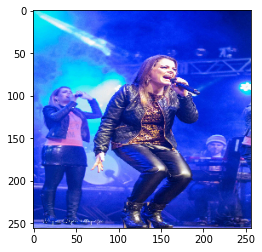

torch.Size([2, 256, 256])


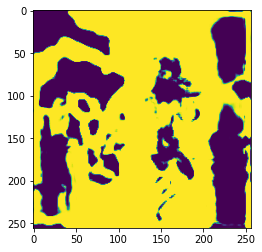

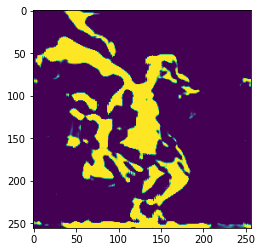

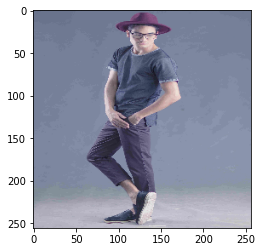

torch.Size([2, 256, 256])


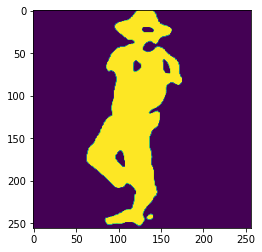

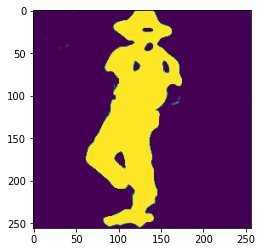

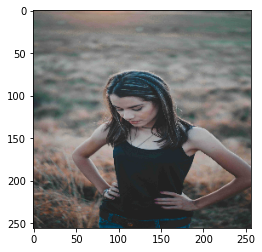

torch.Size([2, 256, 256])


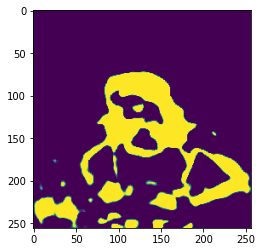

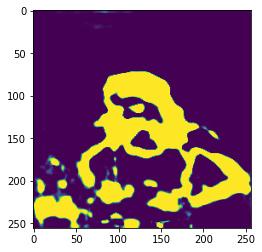

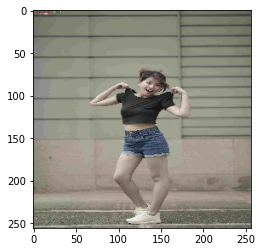

torch.Size([2, 256, 256])


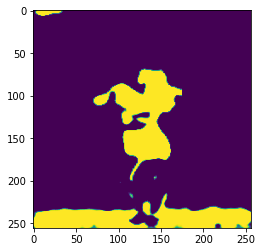

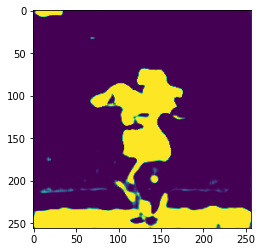

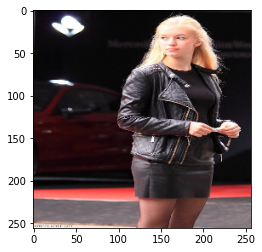

torch.Size([2, 256, 256])


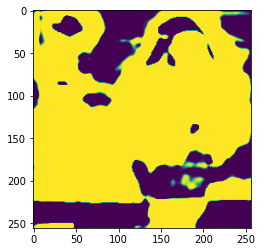

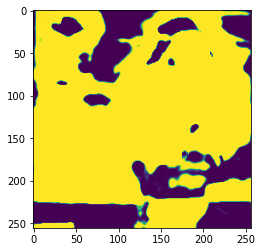

In [76]:
img_height, img_width = 256, 256
for i, image in enumerate(test_list[10:15]):
  # if you want to see the result of the model performance on the test set
  # Than uncomment line below
  image = ROOT_PATH_TEST + '/' +image

  # if you want to see the result of the model performance on the train set
  # uncomment two lines below
  # image = df_val.iloc[i+10]['ImageId'] + '.jpg'
  # image = ROOT_PATH_TRAIN + '/' + image

  img = cv2.imread(image)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (img_width, img_height))
  if img is None:
    continue
  plt.imshow(img)
  plt.show();
  # aug = A.Compose([
  #             A.augmentations.transforms.Resize(img_height, img_width, p=1),
  #         ])
  # aug = aug(image=img)
  # img = aug['image']
  img = img[np.newaxis, :, :, :] # add batch
  # (batch_size, channels, height, width)
  img = img.transpose(0, 3, 1, 2)
  pr_mask = model.predict(torch.tensor(img, dtype=torch.float32))
  pr_mask = pr_mask[0, :, :, :]
  # pr_mask2 = pr_mask[0, 1, :, :]
  # pr_mask3 = pr_mask[0, 2, :, :]
  print(pr_mask.shape)
  for dimm in range(pr_mask.shape[0]):
    plt.imshow(pr_mask[dimm])
    plt.show();